<h1><center>Does the EIA Weekly Petroleum Stock Report <br><i>really</i> impact Crude Oil price?</center></h1>

In [1]:
import pandas as pd
import numpy as np
import datetime as dt

import pytz
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

wall_st = pytz.timezone("America/New_York")

<h2>WPSR Inventory Data</h2>

In [2]:
inv = pd.read_csv("./eia_wpsr.csv", usecols=['Report Date', 'Crude Oil', 'SPR'])

In [3]:
inv.head(3)

,Report Date,Crude Oil,SPR
0,2011-08-03,1074.736,719.761
1,2011-08-10,1067.017,717.267
2,2011-08-17,1065.336,711.353


In [4]:
inv = inv.set_index('Report Date')
inv.index = pd.to_datetime(inv.index, format='%Y-%m-%d').tz_localize(wall_st)
inv = inv.sort_index()

In [5]:
inv.head(2)

,Crude Oil,SPR
Report Date,,
2011-08-03 00:00:00-04:00,1074.736,719.761
2011-08-10 00:00:00-04:00,1067.017,717.267


<h4>Calculate weekly draw/build of Commercial inventories</h4>

In [6]:
inv['Commercial Crude (Excluding SPR)'] = inv['Crude Oil'] - inv['SPR']

In [7]:
inv['Weekly Commercial Draw/Build'] = inv['Commercial Crude (Excluding SPR)'].diff()

In [8]:
inv.head()

,Crude Oil,SPR,Commercial Crude (Excluding SPR),Weekly Commercial Draw/Build
Report Date,,,,
2011-08-03 00:00:00-04:00,1074.736,719.761,354.975,NaN
2011-08-10 00:00:00-04:00,1067.017,717.267,349.750,-5.225
2011-08-17 00:00:00-04:00,1065.336,711.353,353.983,4.233
2011-08-24 00:00:00-04:00,1058.321,706.551,351.770,-2.213
2011-08-31 00:00:00-04:00,1058.876,701.825,357.051,5.281


In [9]:
# drop first report where change is unknown
inv = inv.dropna()

In [10]:
# we can use the report dates DatetimeIndex for a trick shortly
report_dates = inv.index

<h2>WTI Spot Price Data</h2>

We want to know what the overall market impact (i.e. total change percentage) of a report is in the days following its release, until the next report.

In [11]:
first_inventory_date = inv.index.min()
last_inventory_date = inv.index.max()
print(f"First Inventory: {first_inventory_date} \t Last Inventory: {last_inventory_date}")

First Inventory: 2011-08-10 00:00:00-04:00 	 Last Inventory: 2024-05-01 00:00:00-04:00


In [12]:
today = dt.datetime.now(tz=wall_st)
days_per_year = 365.2425
years_ago = int(( today - first_inventory_date).days // days_per_year) + 1

In [13]:
import yfinance as yf

In [14]:
# get relevant historical market data from Yahoo Finance
wti = yf.Ticker("CL=F")
hist = wti.history(period=f"{years_ago}y")

In [15]:
hist.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2011-05-05 00:00:00-04:00,108.779999,109.379997,98.250000,99.800003,670082,0.0,0.0
2011-05-06 00:00:00-04:00,99.760002,102.379997,94.629997,97.180000,606528,0.0,0.0
2011-05-09 00:00:00-04:00,98.110001,103.400002,97.419998,102.550003,469290,0.0,0.0
2011-05-10 00:00:00-04:00,102.440002,103.949997,100.120003,103.879997,439607,0.0,0.0
2011-05-11 00:00:00-04:00,103.690002,104.599998,97.500000,98.209999,524761,0.0,0.0


<h4>Filtering the data period</h4>

We need the data from the day of the first report to six days following the last report (assuming that a week after a new report would have been released).

In [16]:
prices = hist.loc[first_inventory_date:last_inventory_date + dt.timedelta(days=6)].copy()

<h4>Calculating daily market change percentage</h4>

We use percentage change here to account for varying prices over time.

In [17]:
price_changes = 100 * (prices.Close - prices.Open) / prices.Open

In [18]:
# Remove anomalous price movements

In [19]:
price_changes.max()

20.460356387596406

In [20]:
price_changes.min()

-312.2391542000506

<Axes: >

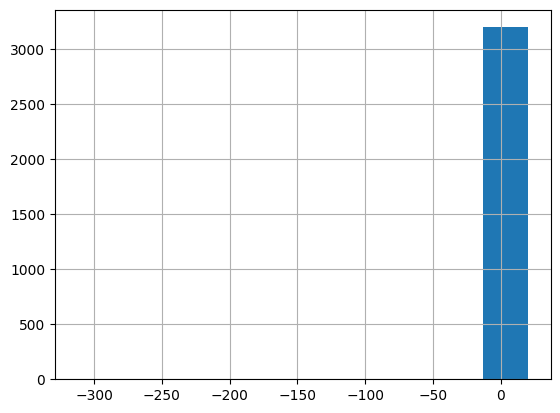

In [21]:
price_changes.hist()

<h4>Removing outlying price movements</h4>

Outlying price movements may overwhelm any impact caused by the WPSR. We can identify and remove outliers using the Z-Score.

This is a statistical measurement of the price change in relationship to the mean of all price changes.

In [22]:
from scipy.stats import zscore

In [23]:
zscores = zscore(price_changes)

In [24]:
zscores

Date
2011-08-10 00:00:00-04:00    0.201673
2011-08-11 00:00:00-04:00    0.705134
2011-08-12 00:00:00-04:00   -0.007263
2011-08-15 00:00:00-04:00    0.419405
2011-08-16 00:00:00-04:00   -0.152145
                               ...   
2024-04-29 00:00:00-04:00   -0.165781
2024-04-30 00:00:00-04:00   -0.126639
2024-05-01 00:00:00-04:00   -0.429583
2024-05-02 00:00:00-04:00   -0.015275
2024-05-03 00:00:00-04:00   -0.180521
Length: 3203, dtype: float64

In [25]:
zscores.max()

3.0594562562529393

In [26]:
zscores.min()

-46.3278439324072

We can discount any days when the absolute Z-score is greater than 3, which translates to 3 Standard Deviations beyond the mean price change.

In [27]:
price_changes = price_changes[zscores.abs() < 3]

<Axes: >

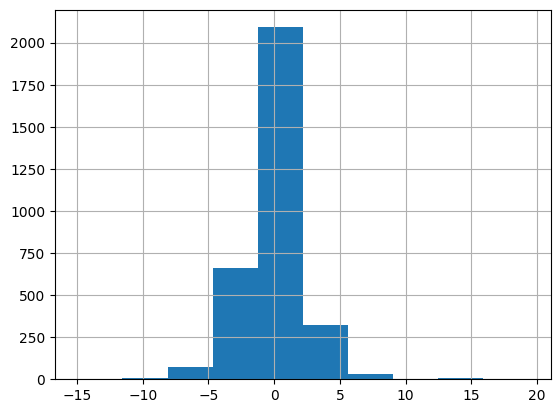

In [28]:
price_changes.hist()

<h2>Building our Market Impact dataframe</h2>

<h4>Grouping daily changes according to the last published report</h4>

For each day in <code>price_changes</code>, we can search for the corresponding index location in the <code>report_dates</code> index

In [29]:
report_dates.searchsorted(price_changes.index)

array([  0,   1,   1, ..., 664, 665, 665])

We want to include the index of the day that the report was issued, since the release of the report may have driven a change under our hypothesis. Therefore, we use the <code>side</code> keyword argument to return the index to the right of the report date, and subtract <code>1</code> from the results to give the index of the last issued report.

In [30]:
last_issued_index = report_dates.searchsorted(price_changes.index, side='right') - 1

In [31]:
last_issued_index

array([  0,   0,   0, ..., 664, 664, 664])

In [32]:
report_dates[last_issued_index]

DatetimeIndex(['2011-08-10 00:00:00-04:00', '2011-08-10 00:00:00-04:00',
               '2011-08-10 00:00:00-04:00', '2011-08-10 00:00:00-04:00',
               '2011-08-10 00:00:00-04:00', '2011-08-17 00:00:00-04:00',
               '2011-08-17 00:00:00-04:00', '2011-08-17 00:00:00-04:00',
               '2011-08-17 00:00:00-04:00', '2011-08-17 00:00:00-04:00',
               ...
               '2024-04-17 00:00:00-04:00', '2024-04-17 00:00:00-04:00',
               '2024-04-24 00:00:00-04:00', '2024-04-24 00:00:00-04:00',
               '2024-04-24 00:00:00-04:00', '2024-04-24 00:00:00-04:00',
               '2024-04-24 00:00:00-04:00', '2024-05-01 00:00:00-04:00',
               '2024-05-01 00:00:00-04:00', '2024-05-01 00:00:00-04:00'],
              dtype='datetime64[ns, America/New_York]', name='Report Date', length=3198, freq=None)

Since we have a list of values equal to length of the <code>price_changes</code>, we can pass these into the <code>pd.Series.groupby</code> as the mapper to determine the groups based on the list values, in this case, the last report date. Then, we can use the <code>sum</code> aggregator to return the total price change percentage for the days following a WPSR report.

In [33]:
report_impact = price_changes.groupby(report_dates[last_issued_index]).sum()

In [34]:
report_impact.head()

Report Date
2011-08-10 00:00:00-04:00    7.111262
2011-08-17 00:00:00-04:00   -0.787683
2011-08-24 00:00:00-04:00    3.748321
2011-08-31 00:00:00-04:00    0.397778
2011-09-08 00:00:00-04:00    0.235214
dtype: float64

Let's create a new dataframe containing the reported inventory level and the subsequent spot price change:

In [35]:
market_impact = pd.DataFrame()
market_impact['inv_change'] = inv['Weekly Commercial Draw/Build'].copy()
market_impact['spot_change'] = report_impact.copy()
market_impact = market_impact.dropna().round(4)

In [36]:
market_impact.head()

,inv_change,spot_change
Report Date,,
2011-08-10 00:00:00-04:00,-5.225,7.1113
2011-08-17 00:00:00-04:00,4.233,-0.7877
2011-08-24 00:00:00-04:00,-2.213,3.7483
2011-08-31 00:00:00-04:00,5.281,0.3978
2011-09-08 00:00:00-04:00,-3.963,0.2352


<h2>Visualising the distribution</h2>

Text(0, 0.5, 'Week-following Spot Price Change (%)')

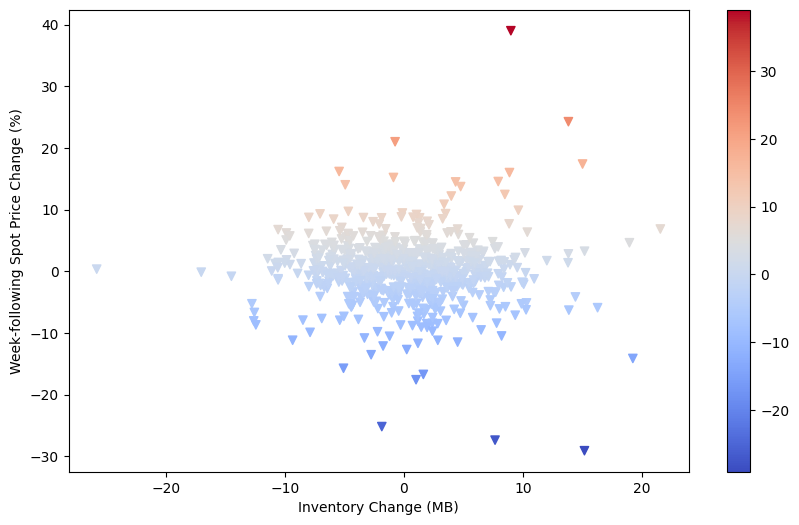

In [37]:
y = market_impact.spot_change
x = market_impact.inv_change

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.colorbar()
plt.xlabel('Inventory Change (MB)')
plt.ylabel('Week-following Spot Price Change (%)')

This distribution predominantly resembles a Bivariate normal distribution.

We can test for the correlation between the Inventory Change and the Spot price Change using Pearsons Correlation Coefficient:

<h4>Covariance</h4>

$Cov(X, Y) = E[(X - E[X])(Y - E[Y])]$

In [38]:
cov = market_impact['inv_change'].cov(market_impact['spot_change'])
cov

-0.4595663892811851

<h4>Correlation Coefficient</h4>

$\rho_{X,Y} = \frac{Cov(X, Y)}{\sigma_X \sigma_Y}$

In [39]:
rho = cov / (market_impact['inv_change'].std() * market_impact['spot_change'].std())

In [40]:
rho

-0.01646075352435643

<h2>Statistical Analysis: Correlation or no correlation?</h2>

<h3>Pearson Correlation</h3>

In [41]:
from scipy.stats import pearsonr, MonteCarloMethod, PermutationMethod
rng = np.random.default_rng()

This function performs a test of the null hypothesis that the distributions underlying the samples are uncorrelated and normally distributed.

In [42]:
market_impact.corr(method='pearson')

,inv_change,spot_change
inv_change,1.000000,-0.016461
spot_change,-0.016461,1.000000


In [43]:
res = pearsonr(market_impact.inv_change.values, market_impact.spot_change.values)

In [44]:
res.confidence_interval(0.95)

ConfidenceInterval(low=-0.09237430682816464, high=0.059643049083104506)

In [45]:
# Permutation Test

In [46]:
method = PermutationMethod(n_resamples=10000, random_state=rng)

pearsonr(market_impact.inv_change.values, market_impact.spot_change.values, method=method)

PearsonRResult(statistic=-0.016460753524356483, pvalue=0.6723327667233276)

In [47]:
# Monte Carlo resampling

In [48]:
# Testing under null hypothesis that samples drawn from uniform distributions

In [49]:
method = MonteCarloMethod(rvs=(rng.uniform, rng.uniform))

pearsonr(market_impact.inv_change.values, market_impact.spot_change.values, method=method)

PearsonRResult(statistic=-0.016460753524356483, pvalue=0.6742)

In [50]:
# Testing under null hypothesis that samples drawn from normal distribution

In [51]:
method = MonteCarloMethod(rvs=(rng.normal, rng.normal))

pearsonr(market_impact.inv_change.values, market_impact.spot_change.values, method=method)

PearsonRResult(statistic=-0.016460753524356483, pvalue=0.6694)

<h3>Kendall (Ordinal) Correlation</h3>

In [52]:
market_impact.corr(method='kendall')

,inv_change,spot_change
inv_change,1.000000,-0.045952
spot_change,-0.045952,1.000000


<h3>Spearman Rank Correlation</h3>

In [53]:
market_impact.corr(method='spearman')

,inv_change,spot_change
inv_change,1.000000,-0.068917
spot_change,-0.068917,1.000000


<h3>Using dichotomous price change</h3>

Text(0, 0.5, 'Week-following Spot Price Direction [-1, 1]')

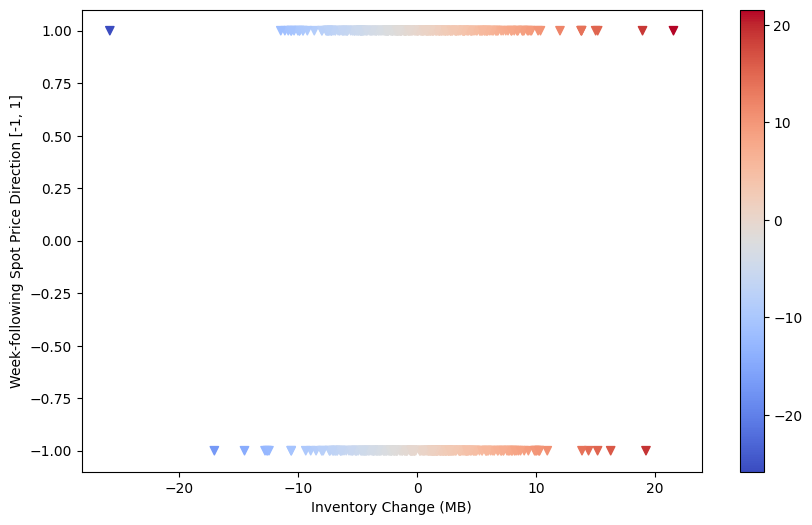

In [54]:
y = np.where(market_impact.spot_change > 0, 1, -1)
x = market_impact.inv_change

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=x, marker='v', cmap='coolwarm')
plt.colorbar()
plt.xlabel('Inventory Change (MB)')
plt.ylabel('Week-following Spot Price Direction [-1, 1]')

In [55]:
change_dir = np.where(market_impact.spot_change > 0, 1, -1)

In [56]:
res = pearsonr(market_impact.inv_change, change_dir)

<h3>Considering only the report date</h3>

In [57]:
shared_index = report_dates.intersection(price_changes.index)

In [58]:
report_impact = price_changes.loc[shared_index]

In [59]:
market_impact = pd.DataFrame()
market_impact['inv_change'] = inv.loc[shared_index, 'Weekly Commercial Draw/Build'].copy()
market_impact['spot_change'] = report_impact.loc[shared_index].copy()

Text(0, 0.5, 'Week-following Spot Price Change (%)')

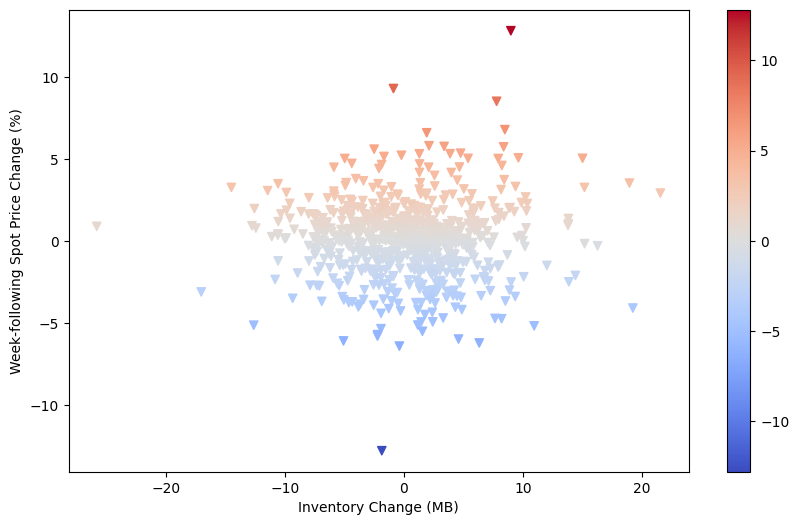

In [60]:
y = market_impact.spot_change
x = market_impact.inv_change

plt.figure(figsize=(10, 6))
plt.scatter(x, y, c=y, marker='v', cmap='coolwarm')
plt.colorbar()
plt.xlabel('Inventory Change (MB)')
plt.ylabel('Week-following Spot Price Change (%)')

In [61]:
market_impact.corr()

,inv_change,spot_change
inv_change,1.000000,0.013108
spot_change,0.013108,1.000000


<h2>Testing the Null Hypothesis</h2>

Permutation tests provide a direct approach to performing hypothesis tests and constructing confidence intervals. A permutation test for Pearson's correlation coefficient involves the following two steps:

    Using the original paired data (xi, yi), randomly redefine the pairs to create a new data set (xi, yi′), where the i′ are a permutation of the set {1,...,n}. The permutation i′ is selected randomly, with equal probabilities placed on all n! possible permutations. This is equivalent to drawing the i′ randomly without replacement from the set {1, ..., n}. In bootstrapping, a closely related approach, the i and the i′ are equal and drawn with replacement from {1, ..., n};
    Construct a correlation coefficient r from the randomized data.

To perform the permutation test, repeat steps (1) and (2) a large number of times. The p-value for the permutation test is the proportion of the r values generated in step (2) that are larger than the Pearson correlation coefficient that was calculated from the original data. Here "larger" can mean either that the value is larger in magnitude, or larger in signed value, depending on whether a two-sided or one-sided test is desired. 

In [62]:
from scipy.stats import permutation_test

In [63]:
from scipy.stats import pearsonr

In [64]:
def generate_new_data(xs, ys):
    i_perm = np.random.randint(0, len(xs), (len(xs),))
    y_i = market_impact.spot_change.iloc[i_perm].values

    

In [65]:
i_perm = np.random.randint(0, len(market_impact), (len(market_impact),))
y_i = market_impact.spot_change.iloc[i_perm].values

In [66]:
repetitions = 100


In [67]:
len(market_impact)

664

In [68]:
len(market_impact.dropna())

664

In [69]:
pearsonr(market_impact.inv_change.values, y_i)

PearsonRResult(statistic=-0.03006701828403941, pvalue=0.4392336591563439)

In [70]:
x = market_impact.inv_change.values

<h3>Bayesian Forecasting</h3>

In [71]:
price_down = market_impact['spot_change'] < 0
price_up = market_impact['spot_change'] > 0
inv_down = market_impact['inv_change'] < 0
inv_up = market_impact['inv_change'] > 0

In [72]:
price_down_inv_down = len(market_impact[price_down&inv_down])
price_down_inv_up = len(market_impact[price_down&inv_up])
price_up_inv_down = len(market_impact[price_up&inv_down])
price_up_inv_up = len(market_impact[price_up&inv_up])

In [73]:
prob_pd = len(market_impact[price_down]) / (len(market_impact[price_down]) + len(market_impact[price_up]))
prob_pu = len(market_impact[price_up]) / (len(market_impact[price_down]) + len(market_impact[price_up]))

prob_id = len(market_impact[inv_down]) / (len(market_impact[inv_down]) + len(market_impact[inv_up]))
prob_iu = len(market_impact[inv_up]) / (len(market_impact[inv_down]) + len(market_impact[inv_up]))

$$P(price_d | inventory_i) = \frac{P(price_d) \times P(inventory_i|price_d)}{P(inventory_i)}$$

$P(inventory_i|price_d)$

In [74]:
prob_ii_pd = price_down_inv_up / (price_down_inv_down + price_down_inv_up)
prob_ii_pd

0.5474683544303798

$P(price_d)$

In [75]:
prob_pd

0.48024316109422494

$P(inventory_i)$

In [76]:
prob_iu

0.5143288084464555

In [77]:
prob_pd_ii = (prob_pd * prob_ii_pd) / prob_iu

In [78]:
prob_pd_ii

0.5111864799579282

<h2>Seasonality</h2>

In [79]:
market_impact

,inv_change,spot_change
2011-08-10 00:00:00-04:00,-5.225,1.208789
2011-08-17 00:00:00-04:00,4.233,0.551095
2011-08-24 00:00:00-04:00,-2.213,-0.595301
2011-08-31 00:00:00-04:00,5.281,0.022521
2011-09-08 00:00:00-04:00,-3.963,-1.176337
...,...,...
2024-04-03 00:00:00-04:00,3.210,-0.035103
2024-04-10 00:00:00-04:00,5.841,1.019455
2024-04-17 00:00:00-04:00,2.735,-3.127927
2024-04-24 00:00:00-04:00,-6.368,-0.707439


In [80]:
seasonal_months = dict(winter=[12, 1, 2], spring=[3, 4, 5], summer=[6, 7, 8], autumn=[9, 10, 11])
month_to_season = {month: season for season, months in seasonal_months.items() for month in months}

In [81]:
market_impact['season'] = market_impact.index.month.map(month_to_season)

In [82]:
market_impact.head(3)

,inv_change,spot_change,season
2011-08-10 00:00:00-04:00,-5.225,1.208789,summer
2011-08-17 00:00:00-04:00,4.233,0.551095,summer
2011-08-24 00:00:00-04:00,-2.213,-0.595301,summer


Text(0, 0.5, 'Week-following Spot Price Change (%)')

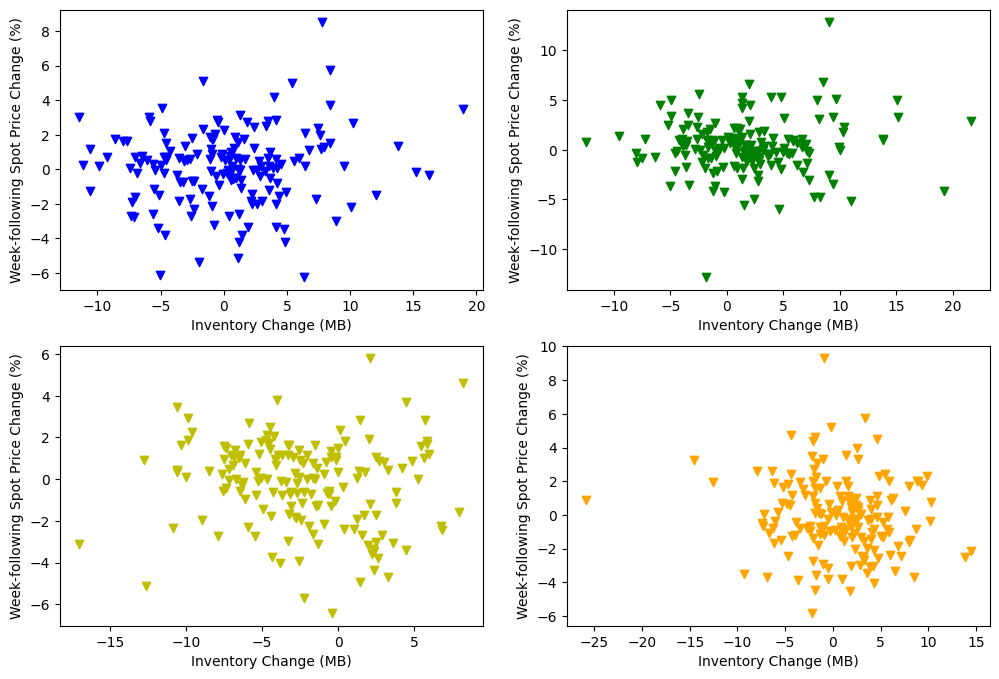

In [83]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8))
seasons = list(market_impact['season'].unique())
colors = np.linspace(0, 1, len(seasons))
colordict = dict(zip(seasons, colors))  

# Winter
winter = market_impact[market_impact['season']=='winter']
x = winter.inv_change
y = winter.spot_change

axs[0][0].scatter(x, y, color='b', marker='v')#, cmap='coolwarm')
# plt.colorbar()
axs[0][0].set_xlabel('Inventory Change (MB)')
axs[0][0].set_ylabel('Week-following Spot Price Change (%)')


# Spring
spring = market_impact[market_impact['season']=='spring']
x = spring.inv_change
y = spring.spot_change

axs[0][1].scatter(x, y, color='g', marker='v')#, cmap='coolwarm')
# plt.colorbar()
axs[0][1].set_xlabel('Inventory Change (MB)')
axs[0][1].set_ylabel('Week-following Spot Price Change (%)')

# Summer
summer = market_impact[market_impact['season']=='summer']
x = summer.inv_change
y = summer.spot_change

axs[1][0].scatter(x, y, color='y', marker='v')#, cmap='coolwarm')
# plt.colorbar()
axs[1][0].set_xlabel('Inventory Change (MB)')
axs[1][0].set_ylabel('Week-following Spot Price Change (%)')

# Autumn
autumn = market_impact[market_impact['season']=='autumn']
x = autumn.inv_change
y = autumn.spot_change

axs[1][1].scatter(x, y, color='orange', marker='v')#, cmap='coolwarm')
# plt.colorbar()
axs[1][1].set_xlabel('Inventory Change (MB)')
axs[1][1].set_ylabel('Week-following Spot Price Change (%)')
